In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


In [98]:
greater_melbourne = pd.read_csv("../data/curated/final_datasets/greater_melbourne_train.csv")
rest_of_vic = pd.read_csv("../data/curated/final_datasets/rest_of_vic_train.csv")

In [99]:
greater_melbourne.head()

,beds,baths,parking,dist_to_city,dist_to_education,dist_to_parks_and_gardens,dist_to_train_station,dist_to_healthcare,weekly_cost,num_homeless_persons,...,median_income,median_age,percent_aboriginal_torres_strait_islander,percent_au_citizen,percent_overseas_born,percent_rental_properties,population,percent_unemployed,housing_index,cpi_without_housing
0,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,680.0,34.666667,...,69755.0,42.46,0.313333,4.393333,35.14,43.72,14208.250639,4.573333,145.288421,127.830132
1,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,775.0,34.666667,...,69755.0,42.46,0.313333,4.393333,35.14,43.72,14208.250639,4.573333,145.288421,127.830132
2,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,775.0,34.666667,...,69358.0,42.12,0.303333,4.673333,34.76,43.58,13106.132992,4.543333,141.520263,125.573860
3,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,680.0,34.666667,...,68564.0,41.44,0.283333,5.233333,34.00,43.30,12696.762148,4.483333,133.983947,121.061316
4,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,675.0,34.666667,...,68564.0,41.44,0.283333,5.233333,34.00,43.30,12696.762148,4.483333,133.983947,121.061316


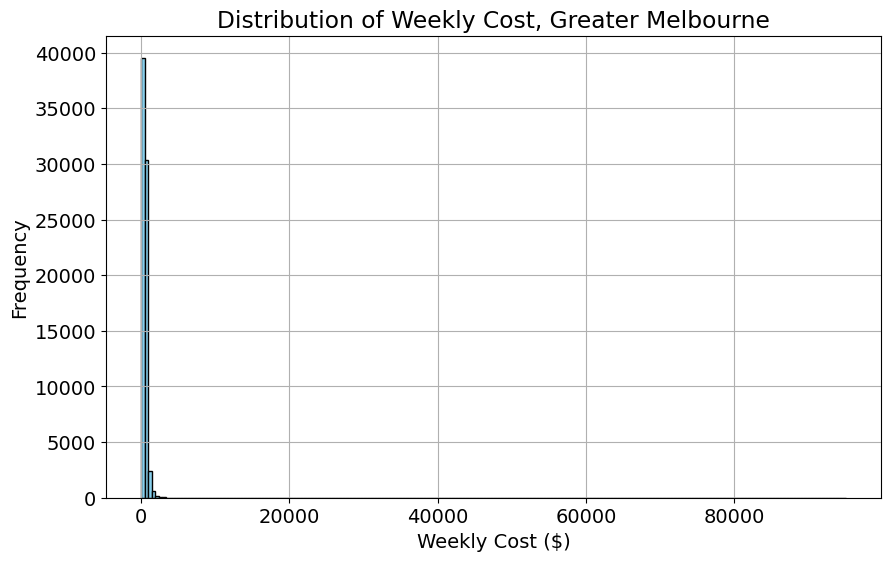

In [100]:
plt.figure(figsize=(10, 6))
plt.hist(greater_melbourne['weekly_cost'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Cost, Greater Melbourne')
plt.xlabel('Weekly Cost ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

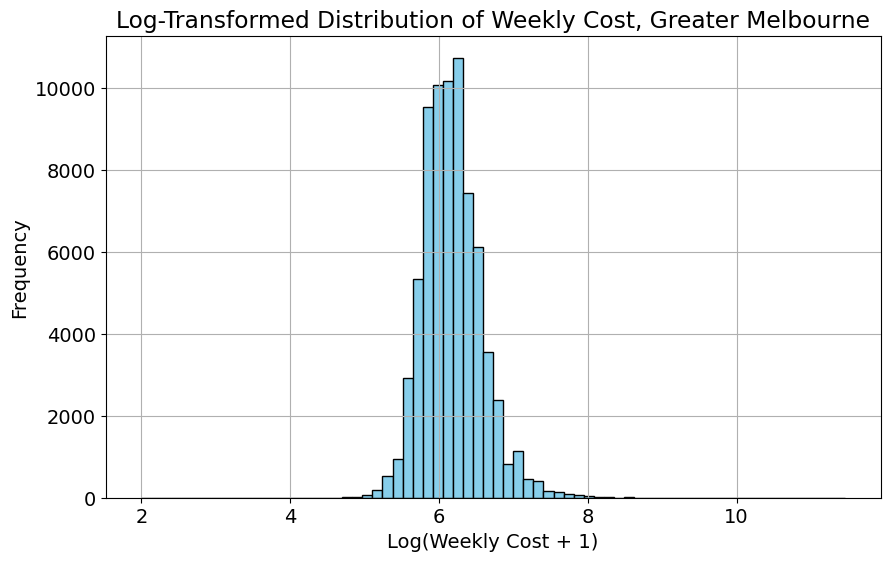

In [101]:
# Log transformation of the 'weekly_cost' column
log_weekly_cost = np.log1p(greater_melbourne['weekly_cost'])

# Plot the log-transformed distribution
plt.figure(figsize=(10, 6))
plt.hist(log_weekly_cost, bins=70, color='skyblue', edgecolor='black')
plt.title('Log-Transformed Distribution of Weekly Cost, Greater Melbourne')
plt.xlabel('Log(Weekly Cost + 1)')
plt.ylabel('Frequency')
plt.grid(True)

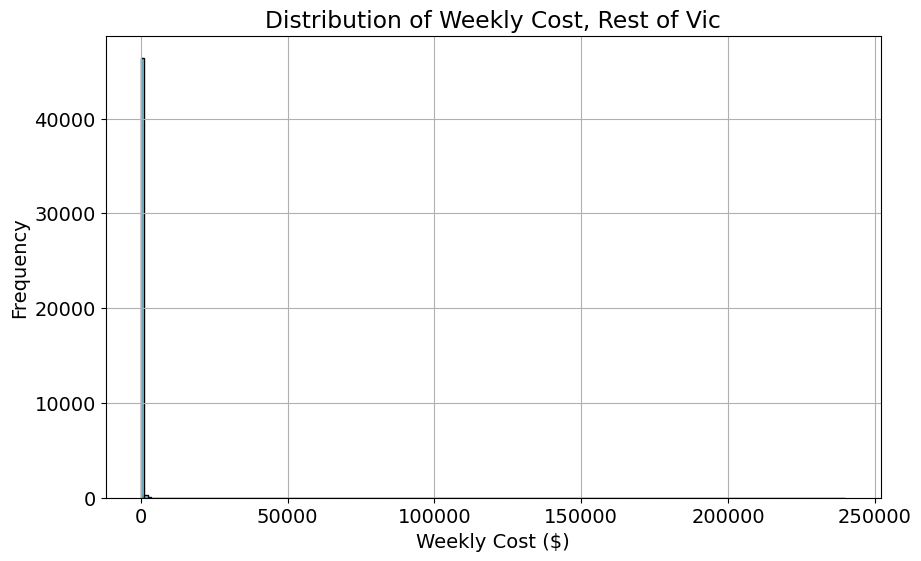

In [102]:
plt.figure(figsize=(10, 6))
plt.hist(rest_of_vic['weekly_cost'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Cost, Rest of Vic')
plt.xlabel('Weekly Cost ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

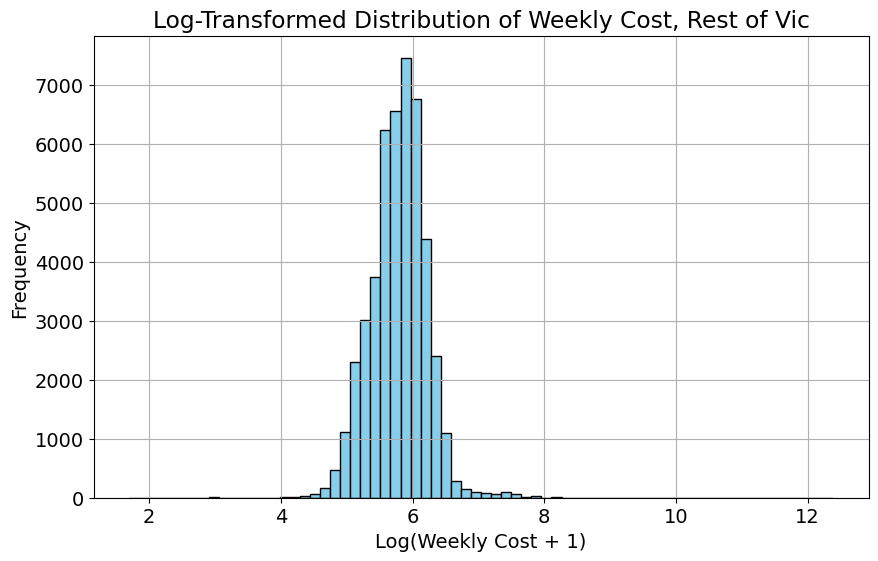

In [103]:
# Log transformation of the 'weekly_cost' column
log_weekly_cost = np.log1p(rest_of_vic['weekly_cost'])

# Plot the log-transformed distribution
plt.figure(figsize=(10, 6))
plt.hist(log_weekly_cost, bins=70, color='skyblue', edgecolor='black')
plt.title('Log-Transformed Distribution of Weekly Cost, Rest of Vic')
plt.xlabel('Log(Weekly Cost + 1)')
plt.ylabel('Frequency')
plt.grid(True)

## GREATER MELBOURNE MODELS:

In [104]:
# REMOVING TOP 5% SO WE ARE ONLY IN THE 95% RANGE

threshold = greater_melbourne['weekly_cost'].quantile(0.95)

# Step 2: Filter the DataFrame to keep only the data less than or equal to the threshold
#greater_melbourne = greater_melbourne[greater_melbourne['weekly_cost'] <= threshold]

Linear Regression MSE (log-transformed scale): 0.05204392446208979
Linear Regression MSE (original scale): 58669.47859141901
Linear Regression RMSE (original scale): 242.21783293436303


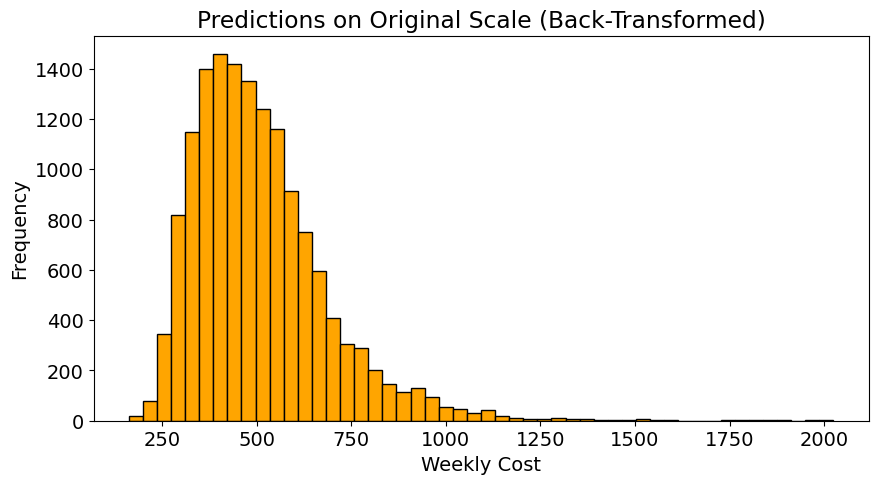


Feature Importances (Coefficients):
Feature: beds, Coefficient: 0.1681
Feature: baths, Coefficient: 0.0982
Feature: parking, Coefficient: 0.0192
Feature: dist_to_city, Coefficient: -0.0328
Feature: dist_to_education, Coefficient: 0.0129
Feature: dist_to_parks_and_gardens, Coefficient: 0.0026
Feature: dist_to_train_station, Coefficient: -0.0087
Feature: dist_to_healthcare, Coefficient: 0.0133
Feature: num_homeless_persons, Coefficient: -0.0114
Feature: avg_household_size, Coefficient: -0.0386
Feature: num_businesses, Coefficient: 0.0253
Feature: median_income, Coefficient: 0.0386
Feature: median_age, Coefficient: 0.0749
Feature: percent_aboriginal_torres_strait_islander, Coefficient: -0.0598
Feature: percent_au_citizen, Coefficient: 0.0128
Feature: percent_overseas_born, Coefficient: -0.0141
Feature: percent_rental_properties, Coefficient: 0.1072
Feature: population, Coefficient: 0.1143
Feature: percent_unemployed, Coefficient: -0.0424
Feature: housing_index, Coefficient: 357246505031.

In [105]:
# REGULAR  LINEAR REGRESSION: 

# Step 1: Drop NaN values
greater_melbourne = greater_melbourne.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_gm = greater_melbourne.drop(columns=['weekly_cost'])
y_gm_log = np.log1p(greater_melbourne['weekly_cost'])  # log1p for better handling of small values

# Step 3: Scale the features
scaler = StandardScaler()
X_gm_scaled = scaler.fit_transform(X_gm)

# Step 4: Split the dataset into training and testing sets
X_train_gm, X_test_gm, y_train_gm, y_test_gm = train_test_split(X_gm_scaled, y_gm_log, test_size=0.2, random_state=42)

# Step 5: Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_gm, y_train_gm)

# Step 6: Make predictions on the test set (log-transformed)
y_pred_lr_gm = lr_model.predict(X_test_gm)

# Step 7: Evaluate the model on the log-transformed data (MSE in log scale)
mse_log = mean_squared_error(y_test_gm, y_pred_lr_gm)
print('Linear Regression MSE (log-transformed scale):', mse_log)

# Step 8: Back-transform the predictions and true values to the original scale
y_pred_lr_gm_orig = np.expm1(y_pred_lr_gm)  # Convert predictions back to the original scale
y_test_gm_orig = np.expm1(y_test_gm)        # Convert true values back to the original scale

# Step 9: Calculate MSE and RMSE on the original scale
mse_original = mean_squared_error(y_test_gm_orig, y_pred_lr_gm_orig)
rmse_original = np.sqrt(mse_original)
print('Linear Regression MSE (original scale):', mse_original)
print('Linear Regression RMSE (original scale):', rmse_original)

# Step 11: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_lr_gm_orig, bins=50, color='orange', edgecolor='black')
plt.title('Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 12: Coefficients with feature names
importance_lr = lr_model.coef_
feature_names = X_gm.columns

print("\nFeature Importances (Coefficients):")
for feature, importance in zip(feature_names, importance_lr):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


In [106]:
# TESTING LASSO REGRESSION AS OPPOSED TO NORMAL REGRESSION: GIVES THE SAME RESULT

from sklearn.linear_model import LassoCV

# Perform Lasso with cross-validation to automatically select the best alpha (penalty)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_gm, y_train_gm)

# Select non-zero coefficient features
lasso_selected_features = X_gm.columns[lasso.coef_ != 0]
print("Selected features by Lasso:", lasso_selected_features)

# Evaluate Lasso model
y_pred_lasso = lasso.predict(X_test_gm)

y_pred_lasso_orig = np.expm1(y_pred_lasso)  # Convert Lasso predictions back to original scale
y_test_gm_orig = np.expm1(y_test_gm)        # Convert true values back to original scale

# Step 5: Calculate MSE and RMSE on the original scale
mse_lasso_original = mean_squared_error(y_test_gm_orig, y_pred_lasso_orig)
rmse_lasso_original = np.sqrt(mse_lasso_original)

# Output the MSE and RMSE for the Lasso model on the original scale
print('Lasso Regression MSE (original scale):', mse_lasso_original)
print('Lasso Regression RMSE (original scale):', rmse_lasso_original)

Selected features by Lasso: Index(['beds', 'baths', 'parking', 'dist_to_city', 'dist_to_education',
       'dist_to_parks_and_gardens', 'dist_to_train_station',
       'dist_to_healthcare', 'num_homeless_persons', 'avg_household_size',
       'num_businesses', 'median_income', 'median_age',
       'percent_aboriginal_torres_strait_islander', 'percent_au_citizen',
       'percent_overseas_born', 'percent_rental_properties', 'population',
       'percent_unemployed', 'housing_index'],
      dtype='object')
Lasso Regression MSE (original scale): 58755.05466367562
Lasso Regression RMSE (original scale): 242.3944196215656


In [107]:
# APPLYING FEATURE ELIMINATION

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Perform Recursive Feature Elimination (RFE)
lr_model_rfe = LinearRegression()
rfe = RFE(lr_model_rfe, n_features_to_select=10)  # Adjust number of features to select
rfe.fit(X_train_gm, y_train_gm)

# Step 2: Selected features
selected_features = X_gm.columns[rfe.support_]
print("Selected features by RFE:", selected_features)

# Step 3: Fit the model using selected features
X_train_selected = rfe.transform(X_train_gm)
X_test_selected = rfe.transform(X_test_gm)
lr_model_rfe.fit(X_train_selected, y_train_gm)

# Step 4: Predictions and evaluation on log-transformed scale
y_pred_rfe = lr_model_rfe.predict(X_test_selected)

# Step 5: Back-transform the predictions and true values to the original scale
y_pred_rfe_orig = np.expm1(y_pred_rfe)  # Convert predictions back to original scale
y_test_gm_orig = np.expm1(y_test_gm)    # Convert true values back to original scale

# Step 6: Calculate MSE and RMSE on the original scale
mse_rfe_original = mean_squared_error(y_test_gm_orig, y_pred_rfe_orig)
rmse_rfe_original = np.sqrt(mse_rfe_original)

# Output the MSE and RMSE on the original scale
print('Linear Regression MSE after RFE (original scale):', mse_rfe_original)
print('Linear Regression RMSE after RFE (original scale):', rmse_rfe_original)


Selected features by RFE: Index(['beds', 'baths', 'avg_household_size', 'median_income', 'median_age',
       'percent_aboriginal_torres_strait_islander',
       'percent_rental_properties', 'population', 'housing_index',
       'cpi_without_housing'],
      dtype='object')
Linear Regression MSE after RFE (original scale): 59767.01289665097
Linear Regression RMSE after RFE (original scale): 244.47292876032506


In [108]:
# WITH INTERACTION TERMS AND FEATURE IMPORTANCE

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Add interaction terms (degree=2 for interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_gm)
X_test_poly = poly.transform(X_test_gm)

# Step 2: Train the linear regression model with interaction terms
lr_model_poly = LinearRegression()
lr_model_poly.fit(X_train_poly, y_train_gm)

# Step 3: Predictions and evaluation (log-transformed scale)
y_pred_poly = lr_model_poly.predict(X_test_poly)
mse_poly = mean_squared_error(y_test_gm, y_pred_poly)
print('Linear Regression MSE with interaction terms (log-transformed scale):', mse_poly)

# Step 4: Back-transform predictions and calculate MSE and RMSE on the original scale
y_pred_poly_orig = np.expm1(y_pred_poly)
mse_poly_original = mean_squared_error(y_test_gm_orig, y_pred_poly_orig)
rmse_poly_original = np.sqrt(mse_poly_original)
print('Linear Regression MSE with interaction terms (original scale):', mse_poly_original)
print('Linear Regression RMSE with interaction terms (original scale):', rmse_poly_original)

# Step 5: Print feature importance (coefficients) with interaction terms
importance_poly = lr_model_poly.coef_

# Get feature names from the PolynomialFeatures object
feature_names_poly = poly.get_feature_names_out(X_gm.columns)

# Print coefficients and corresponding feature names
print("\nFeature Importance (Coefficients) with Interaction Terms:")
for feature, importance in zip(feature_names_poly, importance_poly):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


Linear Regression MSE with interaction terms (log-transformed scale): 0.04126423553261485
Linear Regression MSE with interaction terms (original scale): 50097.965873121924
Linear Regression RMSE with interaction terms (original scale): 223.82574890553124

Feature Importance (Coefficients) with Interaction Terms:
Feature: beds, Coefficient: 0.1663
Feature: baths, Coefficient: 0.0922
Feature: parking, Coefficient: 0.0234
Feature: dist_to_city, Coefficient: -0.0592
Feature: dist_to_education, Coefficient: 0.0049
Feature: dist_to_parks_and_gardens, Coefficient: 0.0108
Feature: dist_to_train_station, Coefficient: 0.0078
Feature: dist_to_healthcare, Coefficient: -0.0179
Feature: num_homeless_persons, Coefficient: 0.0028
Feature: avg_household_size, Coefficient: 0.0139
Feature: num_businesses, Coefficient: 0.0270
Feature: median_income, Coefficient: 0.0381
Feature: median_age, Coefficient: 0.0570
Feature: percent_aboriginal_torres_strait_islander, Coefficient: -0.0626
Feature: percent_au_citi

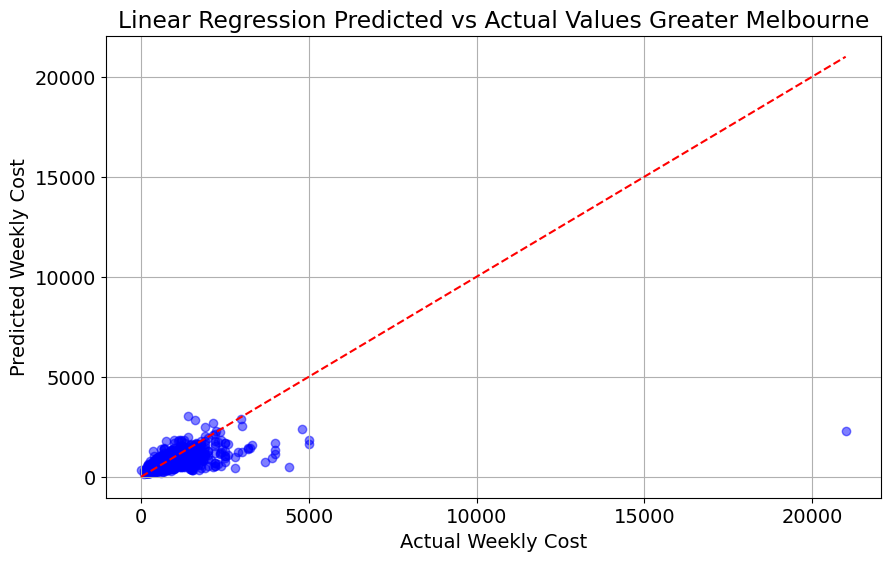

In [109]:
# PREDICTED VS ACTUAL WITH INTERACTION TERMS

plt.figure(figsize=(10, 6))
plt.scatter(y_test_gm_orig, y_pred_poly_orig, alpha=0.5, color='blue')
plt.plot([min(y_test_gm_orig), max(y_test_gm_orig)], [min(y_test_gm_orig), max(y_test_gm_orig)], color='red', linestyle='--')
plt.title('Linear Regression Predicted vs Actual Values Greater Melbourne')
plt.xlabel('Actual Weekly Cost')
plt.ylabel('Predicted Weekly Cost')
plt.grid(True)
plt.show()


In [110]:
# WITH INTERACTION AND FEATURE SELECTION: 

from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Add interaction terms (degree=2 for interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_gm)
X_test_poly = poly.transform(X_test_gm)

# Step 2: Perform Recursive Feature Elimination (RFE)
lr_model_rfe = LinearRegression()
rfe = RFE(lr_model_rfe, n_features_to_select=15)  # Select 15 most important features
rfe.fit(X_train_poly, y_train_gm)

# Step 3: Selected features
selected_features = poly.get_feature_names_out(X_gm.columns)[rfe.support_]
print("Selected features by RFE (with interaction terms):", selected_features)

# Step 4: Train the model using only the selected features
X_train_selected = rfe.transform(X_train_poly)
X_test_selected = rfe.transform(X_test_poly)
lr_model_rfe.fit(X_train_selected, y_train_gm)

# Step 5: Predictions and evaluation (log-transformed scale)
y_pred_rfe = lr_model_rfe.predict(X_test_selected)
mse_rfe = mean_squared_error(y_test_gm, y_pred_rfe)
print('Linear Regression MSE after RFE (log-transformed scale):', mse_rfe)

# Step 6: Back-transform the predictions and calculate MSE and RMSE on the original scale
y_pred_rfe_orig = np.expm1(y_pred_rfe)
mse_rfe_original = mean_squared_error(y_test_gm_orig, y_pred_rfe_orig)
rmse_rfe_original = np.sqrt(mse_rfe_original)

# Step 7: Output MSE and RMSE on original scale
print('Linear Regression MSE after RFE (original scale):', mse_rfe_original)
print('Linear Regression RMSE after RFE (original scale):', rmse_rfe_original)

# Step 8: Print coefficients for the selected features
importance_rfe = lr_model_rfe.coef_

print("\nFeature Importance (Coefficients) for Selected Features after RFE:")
for feature, importance in zip(selected_features, importance_rfe):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


Selected features by RFE (with interaction terms): ['num_homeless_persons housing_index'
 'num_homeless_persons cpi_without_housing'
 'avg_household_size housing_index'
 'avg_household_size cpi_without_housing' 'num_businesses housing_index'
 'num_businesses cpi_without_housing' 'median_income housing_index'
 'median_income cpi_without_housing' 'median_age housing_index'
 'median_age cpi_without_housing'
 'percent_rental_properties housing_index'
 'percent_rental_properties cpi_without_housing'
 'population housing_index' 'population cpi_without_housing'
 'percent_unemployed housing_index']
Linear Regression MSE after RFE (log-transformed scale): 0.14866381382473395
Linear Regression MSE after RFE (original scale): 100774.41640708754
Linear Regression RMSE after RFE (original scale): 317.4498643992269

Feature Importance (Coefficients) for Selected Features after RFE:
Feature: num_homeless_persons housing_index, Coefficient: 447627417951.6645
Feature: num_homeless_persons cpi_without_h

Random Forest MSE (log-transformed scale): 0.02368868722998861
Random Forest MSE (original scale): 41955.376525317246
Random Forest RMSE (original scale): 204.83011625568454


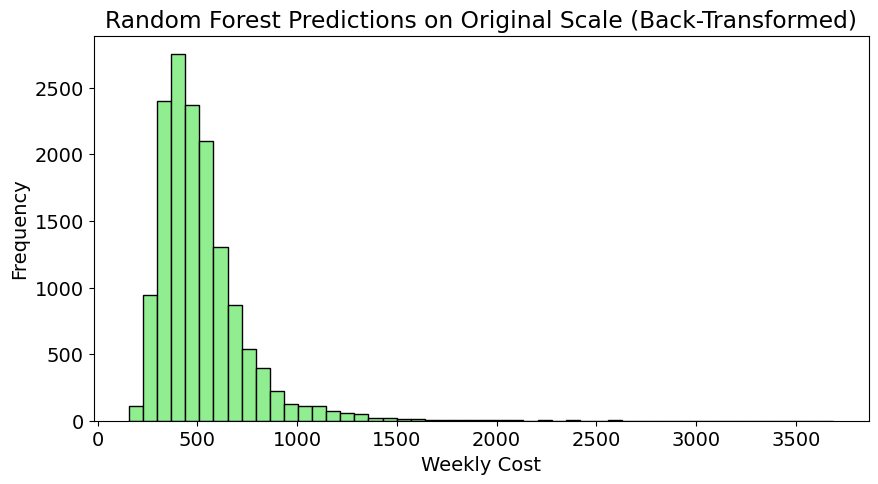


Feature Importances (Random Forest):
Feature: beds, Importance: 0.0883
Feature: baths, Importance: 0.2334
Feature: parking, Importance: 0.0146
Feature: dist_to_city, Importance: 0.1003
Feature: dist_to_education, Importance: 0.0278
Feature: dist_to_parks_and_gardens, Importance: 0.0266
Feature: dist_to_train_station, Importance: 0.0295
Feature: dist_to_healthcare, Importance: 0.0253
Feature: num_homeless_persons, Importance: 0.0085
Feature: avg_household_size, Importance: 0.0238
Feature: num_businesses, Importance: 0.0209
Feature: median_income, Importance: 0.0725
Feature: median_age, Importance: 0.0453
Feature: percent_aboriginal_torres_strait_islander, Importance: 0.0356
Feature: percent_au_citizen, Importance: 0.0120
Feature: percent_overseas_born, Importance: 0.0110
Feature: percent_rental_properties, Importance: 0.0130
Feature: population, Importance: 0.0768
Feature: percent_unemployed, Importance: 0.0255
Feature: housing_index, Importance: 0.0511
Feature: cpi_without_housing, Im

In [111]:
# RANDOM  FOREST: 

# Step 1: Train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune n_estimators
rf_model.fit(X_train_gm, y_train_gm)

# Step 2: Make predictions on the test set (log-transformed)
y_pred_rf_gm = rf_model.predict(X_test_gm)

# Step 3: Evaluate the model on the log-transformed data (MSE in log scale)
mse_rf_log = mean_squared_error(y_test_gm, y_pred_rf_gm)
print('Random Forest MSE (log-transformed scale):', mse_rf_log)

# Step 4: Back-transform the predictions and true values to the original scale
y_pred_rf_gm_orig = np.expm1(y_pred_rf_gm)  # Convert predictions back to the original scale
y_test_gm_orig = np.expm1(y_test_gm)        # Convert true values back to the original scale

# Step 5: Calculate MSE and RMSE on the original scale
mse_rf_original = mean_squared_error(y_test_gm_orig, y_pred_rf_gm_orig)
rmse_rf_original = np.sqrt(mse_rf_original)
print('Random Forest MSE (original scale):', mse_rf_original)
print('Random Forest RMSE (original scale):', rmse_rf_original)

# Step 6: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_rf_gm_orig, bins=50, color='lightgreen', edgecolor='black')
plt.title('Random Forest Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 7: Feature Importances
importance_rf = rf_model.feature_importances_
feature_names = X_gm.columns

print("\nFeature Importances (Random Forest):")
for feature, importance in zip(feature_names, importance_rf):
    print(f'Feature: {feature}, Importance: {importance:.4f}')


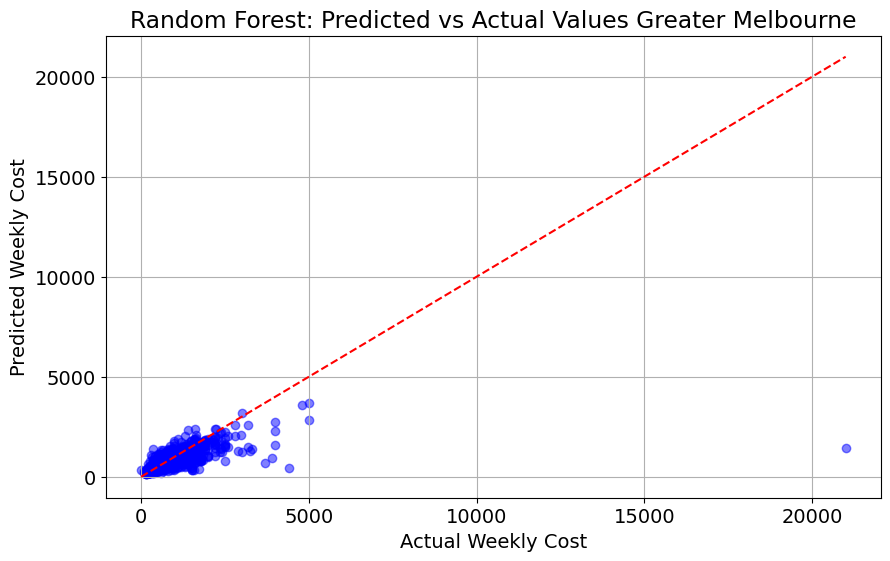

In [112]:
# PLOTTING PREDICTED VS ACTUAL 

plt.figure(figsize=(10, 6))
plt.scatter(y_test_gm_orig, y_pred_rf_gm_orig, alpha=0.5, color='blue')
plt.plot([min(y_test_gm_orig), max(y_test_gm_orig)], [min(y_test_gm_orig), max(y_test_gm_orig)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs Actual Values Greater Melbourne')
plt.xlabel('Actual Weekly Cost')
plt.ylabel('Predicted Weekly Cost')
plt.grid(True)
plt.show()


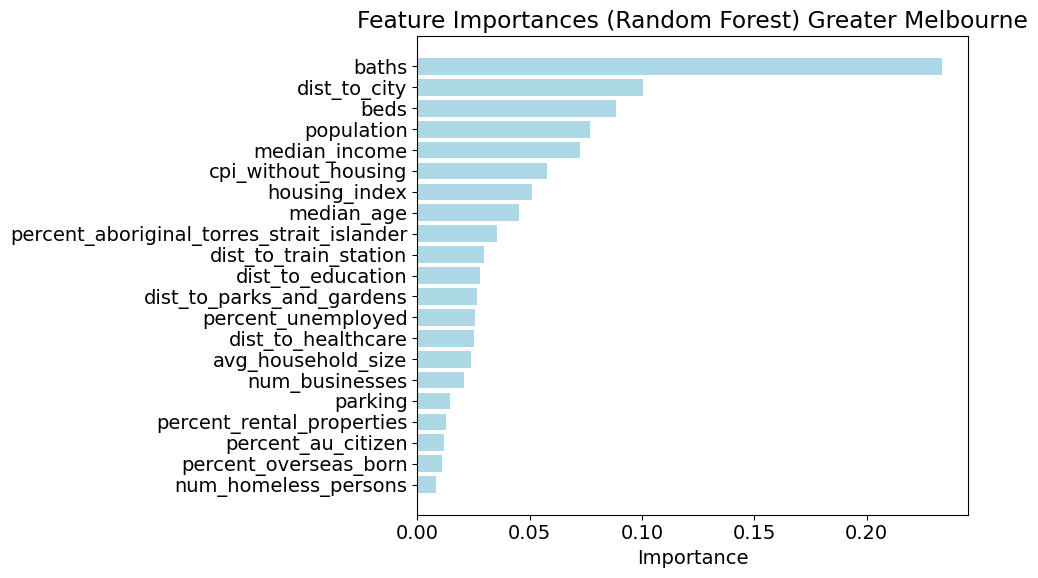

In [113]:
# Plotting feature importances as a bar chart
plt.figure(figsize=(10, 6))

# Sorting the features by importance for better visualization
sorted_idx = np.argsort(importance_rf)[::-1]
sorted_importance_rf = importance_rf[sorted_idx]
sorted_feature_names_rf = feature_names[sorted_idx]

# Create a bar chart
plt.barh(sorted_feature_names_rf, sorted_importance_rf, color='lightblue')
plt.xlabel('Importance')
plt.title('Feature Importances (Random Forest) Greater Melbourne')
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()


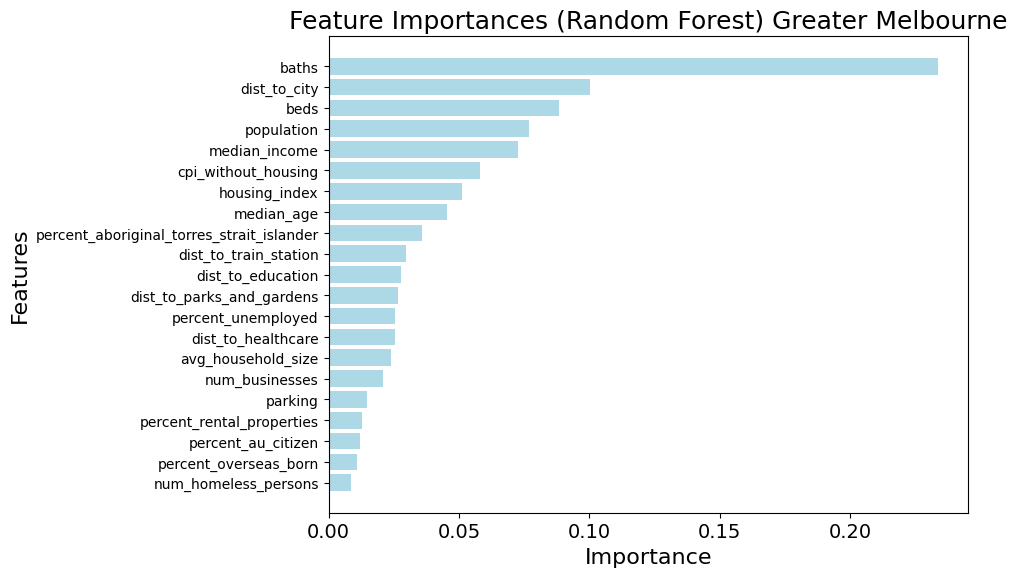

In [114]:
# Set global font size
plt.rc('font', size=14)  # Set default font size for all text elements

# Plotting feature importances as a bar chart
plt.figure(figsize=(10, 6))

# Sorting the features by importance for better visualization
sorted_idx = np.argsort(importance_rf)[::-1]
sorted_importance_rf = importance_rf[sorted_idx]
sorted_feature_names_rf = feature_names[sorted_idx]

# Create a bar chart
plt.barh(sorted_feature_names_rf, sorted_importance_rf, color='lightblue')

# Set axis labels and title with specific font sizes
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)  # Optional, as y-axis label might be redundant for barh
plt.title('Feature Importances (Random Forest) Greater Melbourne', fontsize=18)

# Customize tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)

# Invert the y-axis to display the most important features at the top
plt.gca().invert_yaxis()

# Adjust layout to avoid clipping
plt.tight_layout()

# Show plot
plt.show()


### Save Greater Melbourne models for prediction

In [115]:
import pickle 

In [116]:
# Define path
out_dir = '../models/' 

# Save LR model with interaction (no feature selection)
with open(f"{out_dir}gm_lr.pkl", 'wb') as file:
    pickle.dump(lr_model_poly, file)

# Save the RF model
with open(f"{out_dir}gm_rf.pkl", 'wb') as file:
    pickle.dump(rf_model, file)

## REST OF VIC MODELS

In [117]:
rest_of_vic.head()

,beds,baths,parking,dist_to_city,dist_to_education,dist_to_parks_and_gardens,dist_to_train_station,dist_to_healthcare,weekly_cost,num_homeless_persons,...,median_income,median_age,percent_aboriginal_torres_strait_islander,percent_au_citizen,percent_overseas_born,percent_rental_properties,population,percent_unemployed,housing_index,cpi_without_housing
0,4.0,2.0,2.0,91.83735,2.87569,3.17059,2.96902,4.72762,520.0,47.800000,...,52582.2,45.16,2.400000,15.400000,13.34,27.166667,14208.250639,4.633333,145.288421,127.830132
1,4.0,2.0,2.0,91.83735,2.87569,3.17059,2.96902,4.72762,570.0,47.800000,...,52582.2,45.16,2.400000,15.400000,13.34,27.166667,14208.250639,4.633333,145.288421,127.830132
2,4.0,1.0,2.0,73.33843,6.35949,11.11772,14.49050,14.74958,400.0,54.314085,...,43543.5,52.08,1.860000,10.470000,8.06,8.983333,13106.132992,2.280000,141.520263,125.573860
3,4.0,1.0,2.0,73.33843,6.35949,11.11772,14.49050,14.74958,400.0,51.902817,...,41110.9,51.04,1.700000,9.450000,7.90,8.883333,12696.762148,2.600000,133.983947,121.061316
4,2.0,1.0,3.0,22.60075,0.78947,0.44253,20.22319,18.39855,380.0,15.333333,...,65085.4,37.64,1.533333,4.326667,9.68,10.800000,14208.250639,2.373333,145.288421,127.830132


In [118]:
# REMOVING TOP 5% SO WE ARE ONLY IN THE 95% RANGE
rest_of_vic = rest_of_vic.dropna()

threshold = rest_of_vic['weekly_cost'].quantile(0.95)
# Step 2: Filter the DataFrame to keep only the data less than or equal to the threshold
#rest_of_vic = rest_of_vic[rest_of_vic['weekly_cost'] <= threshold]

Linear Regression MSE (log-transformed scale): 0.07157940857155559
Linear Regression MSE (original scale): 21271.89668835243
Linear Regression RMSE (original scale): 145.84888305486754


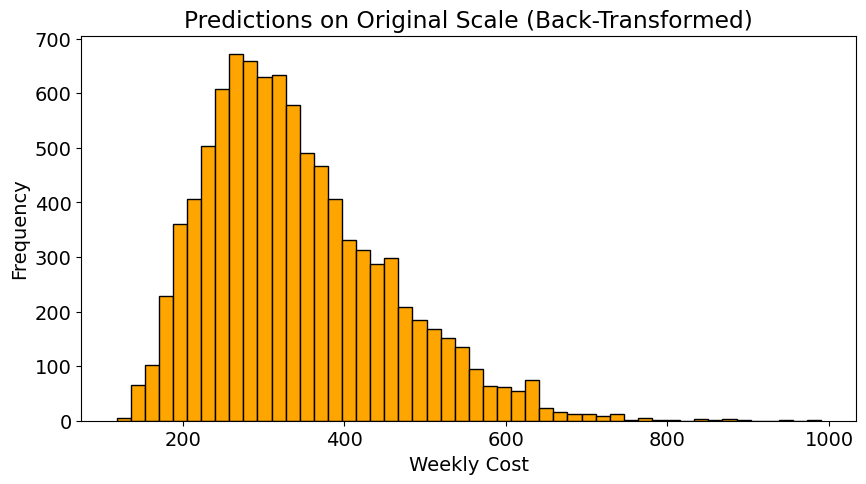


Feature Importances (Coefficients):
Feature: beds, Coefficient: 0.1315
Feature: baths, Coefficient: 0.0805
Feature: parking, Coefficient: 0.0297
Feature: dist_to_city, Coefficient: -0.0619
Feature: dist_to_education, Coefficient: 0.0261
Feature: dist_to_parks_and_gardens, Coefficient: -0.0189
Feature: dist_to_train_station, Coefficient: 0.0086
Feature: dist_to_healthcare, Coefficient: 0.0113
Feature: num_homeless_persons, Coefficient: 0.0150
Feature: avg_household_size, Coefficient: 0.0250
Feature: num_businesses, Coefficient: 0.0085
Feature: median_income, Coefficient: 0.0357
Feature: median_age, Coefficient: 0.0564
Feature: percent_aboriginal_torres_strait_islander, Coefficient: -0.0056
Feature: percent_au_citizen, Coefficient: 0.0061
Feature: percent_overseas_born, Coefficient: 0.0618
Feature: percent_rental_properties, Coefficient: 0.0414
Feature: population, Coefficient: 0.0157
Feature: percent_unemployed, Coefficient: -0.0552
Feature: housing_index, Coefficient: 557907092087.862

In [119]:
# REGULAR  LINEAR REGRESSION: 

# Step 1: Drop NaN values
rest_of_vic = rest_of_vic.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_rov = rest_of_vic.drop(columns=['weekly_cost'])
y_rov_log = np.log1p(rest_of_vic['weekly_cost'])  # log1p for better handling of small values

# Step 3: Scale the features
scaler = StandardScaler()
X_rov_scaled = scaler.fit_transform(X_rov)

# Step 4: Split the dataset into training and testing sets
X_train_rov, X_test_rov, y_train_rov, y_test_rov = train_test_split(X_rov_scaled, y_rov_log, test_size=0.2, random_state=42)

# Step 5: Train the Linear Regression model
lr_model_rov = LinearRegression()
lr_model_rov.fit(X_train_rov, y_train_rov)

# Step 6: Make predictions on the test set (log-transformed)
y_pred_lr_rov = lr_model_rov.predict(X_test_rov)

# Step 7: Evaluate the model on the log-transformed data (MSE in log scale)
mse_log_rov = mean_squared_error(y_test_rov, y_pred_lr_rov)
print('Linear Regression MSE (log-transformed scale):', mse_log_rov)

# Step 8: Back-transform the predictions and true values to the original scale
y_pred_lr_rov_orig = np.expm1(y_pred_lr_rov)  # Convert predictions back to the original scale
y_test_rov_orig = np.expm1(y_test_rov)        # Convert true values back to the original scale

# Step 9: Calculate MSE and RMSE on the original scale
mse_original_rov = mean_squared_error(y_test_rov_orig, y_pred_lr_rov_orig)
rmse_original_rov = np.sqrt(mse_original_rov)
print('Linear Regression MSE (original scale):', mse_original_rov)
print('Linear Regression RMSE (original scale):', rmse_original_rov)

# Step 11: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_lr_rov_orig, bins=50, color='orange', edgecolor='black')
plt.title('Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 12: Coefficients with feature names
importance_lr_rov = lr_model_rov.coef_
feature_names = X_rov.columns

print("\nFeature Importances (Coefficients):")
for feature, importance in zip(feature_names, importance_lr_rov):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


Linear Regression MSE (log-transformed scale): 0.05777679596935401
Linear Regression MSE (original scale): 18466.95989319441
Linear Regression RMSE (original scale): 135.89319296121644


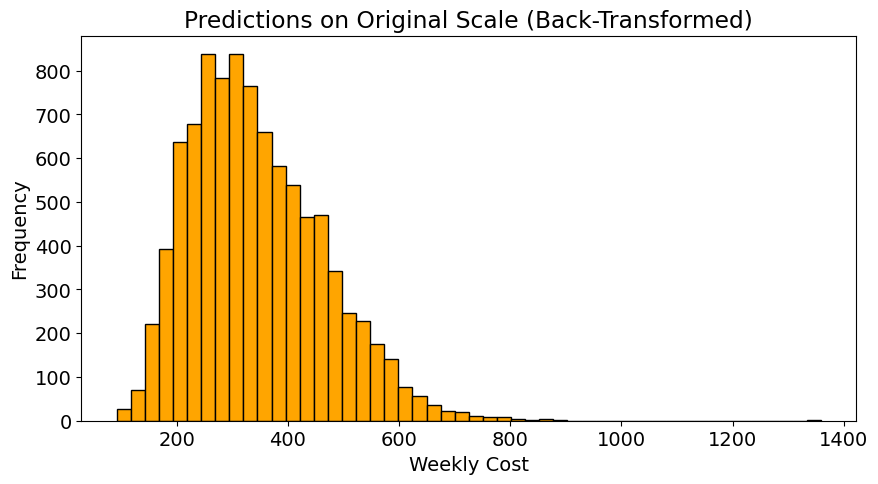


Feature Importances (Coefficients) with Interaction Terms:
Feature: beds, Coefficient: 71460804056.3879
Feature: baths, Coefficient: -55908866584.5100
Feature: parking, Coefficient: 233505738155.6368
Feature: dist_to_city, Coefficient: 192167231082.4782
Feature: dist_to_education, Coefficient: -163282812835.3837
Feature: dist_to_parks_and_gardens, Coefficient: 212690143617.5285
Feature: dist_to_train_station, Coefficient: 131510802596.8272
Feature: dist_to_healthcare, Coefficient: 308608249663.5159
Feature: num_homeless_persons, Coefficient: -30424378103.1817
Feature: avg_household_size, Coefficient: -115059542215.6886
Feature: num_businesses, Coefficient: -114360091829.8778
Feature: median_income, Coefficient: 26527897969.3412
Feature: median_age, Coefficient: 93265499529.5536
Feature: percent_aboriginal_torres_strait_islander, Coefficient: 187404100346.9056
Feature: percent_au_citizen, Coefficient: 352872590384.5717
Feature: percent_overseas_born, Coefficient: -10675373784.2767
Feat

In [120]:
# Step 1: Drop NaN values
rest_of_vic = rest_of_vic.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_rov = rest_of_vic.drop(columns=['weekly_cost'])
y_rov_log = np.log1p(rest_of_vic['weekly_cost'])  # log1p for better handling of small values

# Step 3: Add interaction terms (degree=2 for interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_rov_poly = poly.fit_transform(X_rov)

# Step 4: Scale the features
scaler = StandardScaler()
X_rov_scaled = scaler.fit_transform(X_rov_poly)

# Step 5: Split the dataset into training and testing sets
X_train_rov, X_test_rov, y_train_rov, y_test_rov = train_test_split(X_rov_scaled, y_rov_log, test_size=0.2, random_state=42)

# Step 6: Train the Linear Regression model
lr_model_rov = LinearRegression()
lr_model_rov.fit(X_train_rov, y_train_rov)

# Step 7: Make predictions on the test set (log-transformed)
y_pred_lr_rov = lr_model_rov.predict(X_test_rov)

# Step 8: Evaluate the model on the log-transformed data (MSE in log scale)
mse_log_rov = mean_squared_error(y_test_rov, y_pred_lr_rov)
print('Linear Regression MSE (log-transformed scale):', mse_log_rov)

# Step 9: Back-transform the predictions and true values to the original scale
y_pred_lr_rov_orig = np.expm1(y_pred_lr_rov)  # Convert predictions back to the original scale
y_test_rov_orig = np.expm1(y_test_rov)        # Convert true values back to the original scale

# Step 10: Calculate MSE and RMSE on the original scale
mse_original_rov = mean_squared_error(y_test_rov_orig, y_pred_lr_rov_orig)
rmse_original_rov = np.sqrt(mse_original_rov)
print('Linear Regression MSE (original scale):', mse_original_rov)
print('Linear Regression RMSE (original scale):', rmse_original_rov)

# Step 11: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10, 5))
plt.hist(y_pred_lr_rov_orig, bins=50, color='orange', edgecolor='black')
plt.title('Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 12: Coefficients with feature names
importance_lr_rov = lr_model_rov.coef_

# Get feature names from the PolynomialFeatures object
feature_names_poly = poly.get_feature_names_out(X_rov.columns)

print("\nFeature Importances (Coefficients) with Interaction Terms:")
for feature, importance in zip(feature_names_poly, importance_lr_rov):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


Random Forest MSE (log-transformed scale): 0.02874731526787069
Random Forest MSE (original scale): 14585.729463805555
Random Forest RMSE (original scale): 120.77139340011588


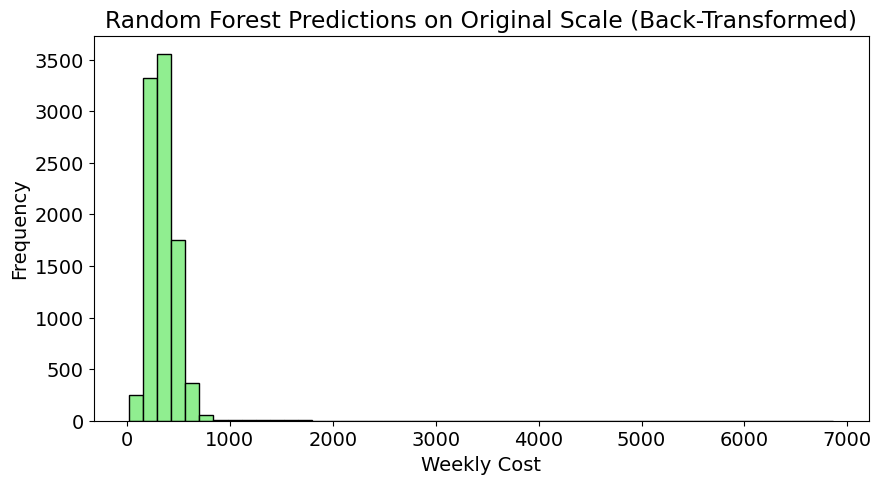


Feature Importances (Random Forest):
Feature: beds, Importance: 0.0908
Feature: baths, Importance: 0.1759
Feature: parking, Importance: 0.0140
Feature: dist_to_city, Importance: 0.0592
Feature: dist_to_education, Importance: 0.0439
Feature: dist_to_parks_and_gardens, Importance: 0.0323
Feature: dist_to_train_station, Importance: 0.0444
Feature: dist_to_healthcare, Importance: 0.0311
Feature: num_homeless_persons, Importance: 0.0141
Feature: avg_household_size, Importance: 0.0106
Feature: num_businesses, Importance: 0.0196
Feature: median_income, Importance: 0.0440
Feature: median_age, Importance: 0.0114
Feature: percent_aboriginal_torres_strait_islander, Importance: 0.0288
Feature: percent_au_citizen, Importance: 0.0123
Feature: percent_overseas_born, Importance: 0.0508
Feature: percent_rental_properties, Importance: 0.0164
Feature: population, Importance: 0.0081
Feature: percent_unemployed, Importance: 0.0253
Feature: housing_index, Importance: 0.1363
Feature: cpi_without_housing, Im

In [121]:
# RANDOM  FOREST: 

# Step 1: Drop NaN values
rest_of_vic = rest_of_vic.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_rov = rest_of_vic.drop(columns=['weekly_cost'])
y_rov_log = np.log1p(rest_of_vic['weekly_cost'])  # log1p for better handling of small values

# Step 3: Scale the features
scaler = StandardScaler()
X_rov_scaled = scaler.fit_transform(X_rov)

# Step 4: Split the dataset into training and testing sets
X_train_rov, X_test_rov, y_train_rov, y_test_rov = train_test_split(X_rov_scaled, y_rov_log, test_size=0.2, random_state=42)


# Step 4: Train the Random Forest Regressor model
rf_model_rov = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune n_estimators
rf_model_rov.fit(X_train_rov, y_train_rov)

# Step 5: Make predictions on the test set (log-transformed)
y_pred_rf_rov = rf_model_rov.predict(X_test_rov)

# Step63: Evaluate the model on the log-transformed data (MSE in log scale)
mse_rf_log_rov = mean_squared_error(y_test_rov, y_pred_rf_rov)
print('Random Forest MSE (log-transformed scale):', mse_rf_log_rov)

# Step 7: Back-transform the predictions and true values to the original scale
y_pred_rf_rov_orig = np.expm1(y_pred_rf_rov)  # Convert predictions back to the original scale
y_test_rov_orig = np.expm1(y_test_rov)        # Convert true values back to the original scale

# Step 8: Calculate MSE and RMSE on the original scale
mse_rf_original_rov = mean_squared_error(y_test_rov_orig, y_pred_rf_rov_orig)
rmse_rf_original_rov = np.sqrt(mse_rf_original_rov)
print('Random Forest MSE (original scale):', mse_rf_original_rov)
print('Random Forest RMSE (original scale):', rmse_rf_original_rov)

# Step 9: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_rf_rov_orig, bins=50, color='lightgreen', edgecolor='black')
plt.title('Random Forest Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 10: Feature Importances
importance_rf_rov = rf_model_rov.feature_importances_
feature_names = X_rov.columns

print("\nFeature Importances (Random Forest):")
for feature, importance in zip(feature_names, importance_rf_rov):
    print(f'Feature: {feature}, Importance: {importance:.4f}')


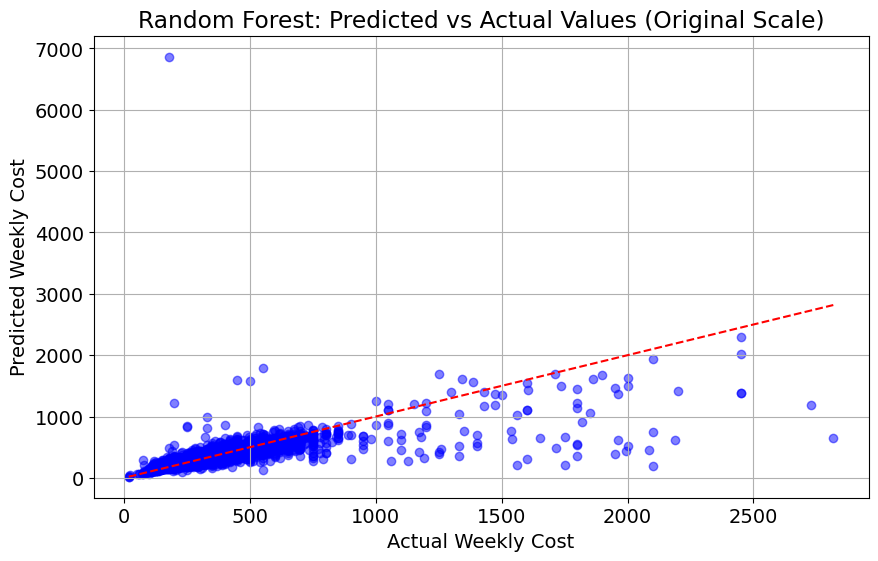

In [122]:
# PLOTTING  PREDICTED VS ACTUAL 

plt.figure(figsize=(10, 6))
plt.scatter(y_test_rov_orig, y_pred_rf_rov_orig, alpha=0.5, color='blue')
plt.plot([min(y_test_rov_orig), max(y_test_rov_orig)], [min(y_test_rov_orig), max(y_test_rov_orig)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs Actual Values (Original Scale)')
plt.xlabel('Actual Weekly Cost')
plt.ylabel('Predicted Weekly Cost')
plt.grid(True)
plt.show()


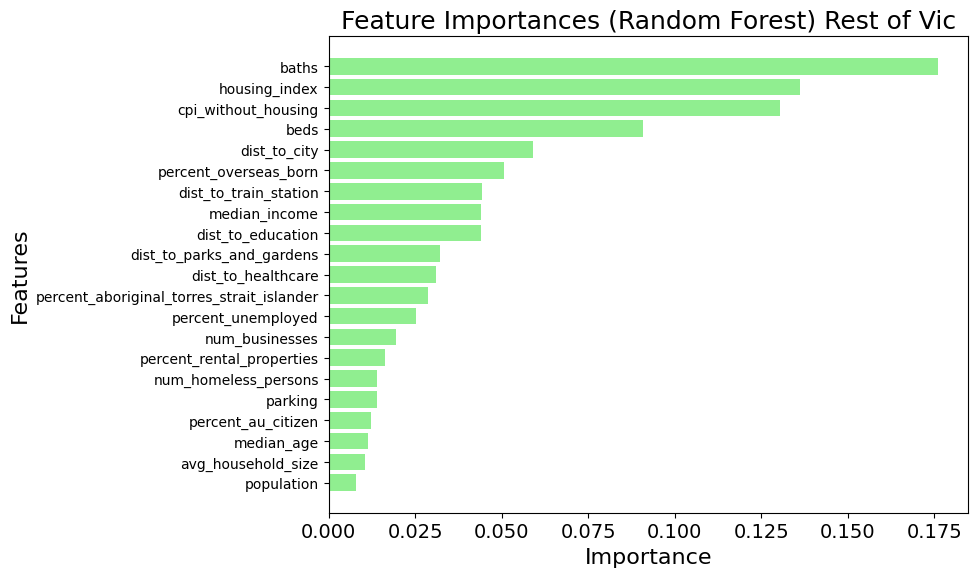

In [123]:
# Set global font size
plt.rc('font', size=14)  # Set default font size for all text

# Plotting feature importances as a bar chart
plt.figure(figsize=(10, 6))

# Sorting the features by importance for better visualization
sorted_idx_rov = np.argsort(importance_rf_rov)[::-1]
sorted_importance_rf_rov = importance_rf_rov[sorted_idx_rov]
sorted_feature_names_rf_rov = feature_names[sorted_idx_rov]

# Create a bar chart
plt.barh(sorted_feature_names_rf_rov, sorted_importance_rf_rov, color='lightgreen')

# Set axis labels and title with specific font sizes
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)  # Optional, y-axis label usually not needed for barh
plt.title('Feature Importances (Random Forest) Rest of Vic', fontsize=18)

# Customize tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)

# Invert the y-axis to display the most important features at the top
plt.gca().invert_yaxis()

# Adjust layout to avoid clipping
plt.tight_layout()

# Show plot
plt.show()


In [124]:
# Define path
out_dir = '../models/' 

# Save LR model with interaction (no feature selection)
with open(f"{out_dir}rv_lr.pkl", 'wb') as file:
    pickle.dump(lr_model_rov, file)

# Save the RF model
with open(f"{out_dir}rv_rf.pkl", 'wb') as file:
    pickle.dump(rf_model_rov, file)